### Clothing Classification

In [11]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [4]:
from tensorflow.keras.preprocessing.image import load_img

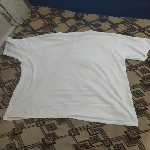

In [7]:
path = './clothing-dataset-small/train/t-shirt/0a85a584-cb49-4795-b2f1-7eebbf09399a.jpg'
load_img(path, target_size = (150, 150)) #Neural nets need a specific size

In [16]:
img = load_img(path, target_size = (299,299))

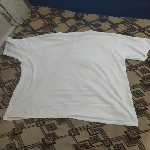

In [9]:
img

In [ ]:
x = np.array(img)
x.shape # The 3 values are RGB values

(150, 150, 3)

### Pre-trained convolutional neural networks

In [23]:
# off-the-shelf model that can be used to predict image class
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions

In [15]:
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

2025-12-27 22:52:26.423125: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [21]:
pred = model.predict(preprocess_input(np.array([img])))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


In [24]:
decode_predictions(pred)

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


[[('n03595614', 'jersey', np.float32(0.9524979)),
  ('n04370456', 'sweatshirt', np.float32(0.009788689)),
  ('n04033995', 'quilt', np.float32(0.0031949775)),
  ('n03710637', 'maillot', np.float32(0.0012328895)),
  ('n03188531', 'diaper', np.float32(0.001185509))]]

### Convolutional Neural Networks

Layers of nodes with weights that output 
- Convolutional layers are filters that are slid on the image to get feature map that show where the image is similar to the filter. Each layer iterates on the prior set of feature maps.
- Dense layers add weights to feature maps and pass to sigmoid function to output class prediction


### Transfer Learning

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
train_ds = train_gen.flow_from_directory('./clothing-dataset-small/train', target_size=(150, 150), batch_size= 32)

Found 3068 images belonging to 10 classes.


In [29]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [31]:
X, y = next(train_ds)

In [32]:
X.shape

(32, 150, 150, 3)

In [33]:
y[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [34]:
val_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
val_ds = val_gen.flow_from_directory('./clothing-dataset-small/validation', target_size=(150, 150), batch_size= 32, shuffle=False)

Found 341 images belonging to 10 classes.


In [35]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(150,150,3)) #only convolutional layer included, no dense layers

base_model.trainable = False #Don't change convulational layers

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [55]:
inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs,training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base) #5x5x2048 has to be turned to 1d array - called pooling
outputs = keras.layers.Dense(10)(vectors)

model = keras.Model(inputs, outputs)

In [56]:
preds = model.predict(X)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [57]:
preds.shape # 

(32, 10)

### Optimizer

Once the model shape is set, optimizer is used to change weights of dense layer so the model learns how to predict accurately

In [58]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate = learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True) #from logits = True applies softmax internally before computing cross-entropy

In [61]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history = model.fit(train_ds, epochs=1, validation_data=val_ds) # epochs mean how many times we iterate over the entire dataset

96/96 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.7314 - loss: 0.9680 - val_accuracy: 0.7625 - val_loss: 1.1050


In [66]:
(history.history['accuracy'],
history.history['val_accuracy'])

([0.7314211130142212], [0.7624633312225342])

### Learning rate

learning fast could mean lower scores, learning slow could take longer time

In [67]:
def make_model(learning_rate: float):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(150,150,3)) #only convolutional layer included, no dense layers

    base_model.trainable = False #Don't change convulational layers

    inputs = keras.Input(shape=(150, 150, 3))

    base = base_model(inputs,training=False)

    vectors = keras.layers.GlobalAveragePooling2D()(base) #5x5x2048 has to be turned to 1d array - called pooling
    outputs = keras.layers.Dense(10)(vectors)

    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)

    loss = keras.losses.CategoricalCrossentropy(from_logits=True) #from logits = True applies softmax internally before computing cross-entropy
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

In [68]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate = lr)
    history = model.fit(train_ds, epochs=1, validation_data=val_ds) # epochs mean how many times we iterate over the entire dataset

    scores[lr] = history.history

    print()
    print()

0.0001
96/96 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.3377 - loss: 1.9751 - val_accuracy: 0.4633 - val_loss: 1.6323


0.001
96/96 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.6294 - loss: 1.1058 - val_accuracy: 0.7537 - val_loss: 0.7385


0.01
96/96 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.6842 - loss: 1.1494 - val_accuracy: 0.7009 - val_loss: 1.0843


0.1
96/96 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.6353 - loss: 11.1121 - val_accuracy: 0.7742 - val_loss: 5.7178




In [69]:
for lr, hist in scores.items():
    print(lr)
    print(hist)

0.0001
{'accuracy': [0.33767926692962646], 'loss': [1.9751473665237427], 'val_accuracy': [0.4633431136608124], 'val_loss': [1.632318139076233]}
0.001
{'accuracy': [0.6294002532958984], 'loss': [1.1057937145233154], 'val_accuracy': [0.7536656856536865], 'val_loss': [0.7385451197624207]}
0.01
{'accuracy': [0.6841590404510498], 'loss': [1.149383544921875], 'val_accuracy': [0.7008797526359558], 'val_loss': [1.084262728691101]}
0.1
{'accuracy': [0.6352672576904297], 'loss': [11.112122535705566], 'val_accuracy': [0.774193525314331], 'val_loss': [5.717803478240967]}


In [70]:
learning_rate = 0.01

### checkpointing 
Saving the best model only, because sometimes the final epoch can return val_accuracy lower than the peak val_accuracy
Checkpointing saves the model that provides the best epoch peak_val accuracy

In [73]:
model.save_weights('model_v1.weights.h5')

In [75]:
checkpoint = keras.callbacks.ModelCheckpoint('xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5', 
                        save_best_only=True,
                        mode='max',
                        monitor = 'val_accuracy') #only save model when accuracy improves

In [76]:
learning_rate = 0.01

model = make_model(learning_rate = learning_rate)
history = model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds,
    callbacks=[checkpoint]
)

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5752 - loss: 1.6427

96/96 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.6770 - loss: 1.1579 - val_accuracy: 0.7889 - val_loss: 0.7948
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8462 - loss: 0.4584

96/96 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.8224 - loss: 0.5537 - val_accuracy: 0.7918 - val_loss: 0.8397
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.8778 - loss: 0.3713 - val_accuracy: 0.7449 - val_loss: 1.0394
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9072 - loss: 0.2663

96/96 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.9149 - loss: 0.2454 - val_accuracy: 0.8328 - val_loss: 0.7440
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.9456 - loss: 0.1586 - val_accuracy: 0.8006 - val_loss: 0.8809


### Adding Layers

add inner layers between pooling and final layer

In [77]:
def make_model_with_inner_layer(learning_rate: float, inner_layer: int):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(150,150,3)) #only convolutional layer included, no dense layers

    base_model.trainable = False #Don't change convulational layers

    inputs = keras.Input(shape=(150, 150, 3))

    base = base_model(inputs,training=False)

    vectors = keras.layers.GlobalAveragePooling2D()(base) #5x5x2048 has to be turned to 1d array - called pooling
    
    inner = keras.layers.Dense(inner_layer, activation='relu')(vectors) # each dense layer needs its own activation function
    
    outputs = keras.layers.Dense(10)(inner)  

    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)

    loss = keras.losses.CategoricalCrossentropy(from_logits=True) #from logits = True applies softmax internally before computing cross-entropy
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

In [80]:
learning_rate = 0.001

scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = make_model_with_inner_layer(learning_rate=learning_rate, inner_layer = size)
    history = model.fit(train_ds, epochs=1, validation_data=val_ds)
    scores[size] = history.history

    print()
    print()

10
96/96 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.5183 - loss: 1.5081 - val_accuracy: 0.7390 - val_loss: 1.0312


100
96/96 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.6649 - loss: 0.9776 - val_accuracy: 0.7625 - val_loss: 0.6896


1000
96/96 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.6809 - loss: 0.9328 - val_accuracy: 0.7977 - val_loss: 0.6588




In [81]:
hist['val_accuracy']

[0.774193525314331]

### Regularization and dropout

Dropout = freeze random subset of neurons of the inner layer to not overfit on certain parts of the image, better for generalization

In [82]:
def make_model_with_inner_layer_and_dropout(learning_rate: float, inner_layer: int, droprate: float):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(150,150,3)) #only convolutional layer included, no dense layers

    base_model.trainable = False #Don't change convulational layers

    inputs = keras.Input(shape=(150, 150, 3))

    base = base_model(inputs,training=False)

    vectors = keras.layers.GlobalAveragePooling2D()(base) #5x5x2048 has to be turned to 1d array - called pooling
    
    inner = keras.layers.Dense(inner_layer, activation='relu')(vectors) # each dense layer needs its own activation function
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(10)(drop)  

    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)

    loss = keras.losses.CategoricalCrossentropy(from_logits=True) #from logits = True applies softmax internally before computing cross-entropy
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

In [ ]:
learning_rate = 0.001
size = 100

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model_with_inner_layer_and_dropout(learning_rate=learning_rate, inner_layer = size, droprate=droprate)
    history = model.fit(train_ds, epochs=1, validation_data=val_ds)
    scores[droprate] = history.history

    print()
    print()

0.0
96/96 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.6773 - loss: 0.9554 - val_accuracy: 0.7889 - val_loss: 0.6583


0.2
96/96 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.6278 - loss: 1.1123 - val_accuracy: 0.7859 - val_loss: 0.6618


0.5
96/96 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.5857 - loss: 1.2522 - val_accuracy: 0.7654 - val_loss: 0.7552


0.8
96/96 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.4094 - loss: 1.7471 - val_accuracy: 0.6393 - val_loss: 1.1287




In [84]:
scores

{100: {'accuracy': [0.4093872308731079],
  'loss': [1.7471364736557007],
  'val_accuracy': [0.6392961740493774],
  'val_loss': [1.1287028789520264]}}

### Data Augmentation

look at the dataset to know what kind of variations are there, add those variations to generator

Generate more images from the same image in training dataset
- flip the image (horizontally, vertically)
- rotate the image (clockwise, counterclockwise)
- shift the image (up, down, left, right)
- shear the image (pulling 1 side of the image)
- zoom in/out
- brightness/contrast

can treat augmentation as hyperparameter and train on epochs


In [85]:
train_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    shear_range = 10.0,
    zoom_range = 0.1,
    vertical_flip = True
    )
train_ds = train_gen.flow_from_directory('./clothing-dataset-small/train', target_size=(150, 150), batch_size= 32)

# validation should have the same images for consistent results
val_gen = ImageDataGenerator(
        preprocessing_function = preprocess_input,
        )
val_ds = val_gen.flow_from_directory('./clothing-dataset-small/validation', target_size=(150, 150), batch_size= 32, shuffle=False)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [86]:
learning_rate = 0.001
size = 100
droprate = 0.2

model = make_model_with_inner_layer_and_dropout(
    learning_rate = learning_rate,
    inner_layer = size,
    droprate = droprate
)

history = model.fit(train_ds, epochs=1, validation_data=val_ds)

96/96 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.5717 - loss: 1.3141 - val_accuracy: 0.7654 - val_loss: 0.7386


In [89]:
history.history['val_accuracy']

[0.7653958797454834]

### Training a larger model

Train a 299x299 model

In [90]:
def make_larger_model(
    learning_rate: float, 
    inner_layer: int, 
    droprate: float,
    input_size=150):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(input_size,input_size,3)) #only convolutional layer included, no dense layers

    base_model.trainable = False #Don't change convulational layers

    inputs = keras.Input(shape=(input_size, input_size, 3))

    base = base_model(inputs,training=False)

    vectors = keras.layers.GlobalAveragePooling2D()(base) #5x5x2048 has to be turned to 1d array - called pooling
    
    inner = keras.layers.Dense(inner_layer, activation='relu')(vectors) # each dense layer needs its own activation function
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(10)(drop)  

    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)

    loss = keras.losses.CategoricalCrossentropy(from_logits=True) #from logits = True applies softmax internally before computing cross-entropy
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

In [91]:
checkpoint = keras.callbacks.ModelCheckpoint('xception_v4_{epoch:02d}_{val_accuracy:.3f}.h5', 
                        save_best_only=True,
                        mode='max',
                        monitor = 'val_accuracy') #only save model when accuracy improves

In [94]:
input_size = 299

train_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    shear_range = 10.0,
    zoom_range = 0.1,
    vertical_flip = True
    )
train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train', target_size=(input_size, input_size), batch_size= 32)

# validation should have the same images for consistent results
val_gen = ImageDataGenerator(
        preprocessing_function = preprocess_input,
        )
val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation', target_size=(input_size, input_size), batch_size= 32, shuffle=False)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [95]:
learning_rate = 0.001
size = 100
droprate = 0.2

model = make_larger_model(
    learning_rate = learning_rate,
    inner_layer = size,
    droprate = droprate,
    input_size = input_size
)

history = model.fit(train_ds, epochs=2, validation_data=val_ds, 
    callbacks=[checkpoint])

Epoch 1/2
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5524 - loss: 1.3833

96/96 ━━━━━━━━━━━━━━━━━━━━ 836s 9s/step - accuracy: 0.6516 - loss: 1.0680 - val_accuracy: 0.8299 - val_loss: 0.5457
Epoch 2/2
96/96 ━━━━━━━━━━━━━━━━━━━━ 818s 9s/step - accuracy: 0.7751 - loss: 0.6679 - val_accuracy: 0.8299 - val_loss: 0.5006


### Using the Model


In [97]:
model = keras.models.load_model('xception_v4_01_0.830.h5')

In [98]:
input_size = 299

test_gen = ImageDataGenerator(
        preprocessing_function = preprocess_input,
        )
test_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/test', target_size=(input_size, input_size), batch_size= 32, shuffle=False)

Found 372 images belonging to 10 classes.


In [99]:
model.evaluate(test_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 90s 7s/step - accuracy: 0.8414 - loss: 0.4503


[0.45032286643981934, 0.8413978219032288]

In [103]:
path = './clothing-dataset-small/test/pants/0dfec862-c49f-430b-a6ef-c7ceb187225e.jpg'
img = load_img(path, target_size=(input_size,input_size))

In [104]:
X = preprocess_input(np.array([np.array(img)]))

In [105]:
pred = model.predict(X)
pred[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


array([-3.203144  , -1.4341435 ,  0.09624216,  1.7828931 ,  6.3060336 ,
        1.4679315 , -2.223834  ,  2.8981442 , -1.3740083 , -2.3721561 ],
      dtype=float32)